In [9]:
collab_mode = False

if collab_mode:
    # set up tensorflow
    %tensorflow_version 2.x
# imports
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import warnings # This ignore all the warning messages
warnings.filterwarnings('ignore')

from os import path
import os
import time

print(tf.__version__)

2.0.0


In [2]:
root_local_path = os.getcwd()
root_gdrive_path = '/content/drive'
gdrive_project_path = 'My Drive/pp/GSN/FaceGenerator'
checkpoints_path = 'checkpoints'
dataset_path = 'datasets'
dataset_name = "celeb_a"
tensorboard_logs_dir='tensorboard'
download_path = '' # output path for the dataset
generated_images_path = 'generated_images'
dataset_image_size = (28, 28)
run_name = ''
gdrive_mounted = False

In [3]:
def allow_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

# run the line below if you're using local runtime and have GTX > 1660 (this is known bug with tensorflow memory allocation)
# allow_memory_growth()

print("Getting device name")
tf.test.gpu_device_name()

Getting device name


'/device:GPU:0'

Misc helper functions

In [18]:
def get_time():
    return time.strftime("%d-%m-%Y-_%H-%M-%S") 

# Mount gdrive disk if necessary

In [4]:
if collab_mode:
    from google.colab import drive
    project_path = path.join(root_gdrive_path, gdrive_project_path )
    gdrive_project_path = path.join(root_gdrive_path, gdrive_project_path)
    drive.mount(root_gdrive_path)
    gdrive_mounted = True

def get_base_path():
    if collab_mode:
        return path.join(root_gdrive_path, gdrive_project_path)
    else:
        return root_local_path 

## Import dataset_helpers

In [5]:
if collab_mode:
    path_with_imports = path.join(root_gdrive_path, gdrive_project_path)
    print("Files in path", path_with_imports)
    !ls /content/drive/My\ Drive/pp/GSN/FaceGenerator
    if path_with_imports not in os.sys.path:
        os.sys.path.append(path_with_imports)

import dataset_helpers as ds_helpers

### Download dataset

In [6]:
def download_dataset():
    '''Downloads data to dataset_path/dataset_name directory'''
    if collab_mode:
        download_path = path.join(root_gdrive_path, gdrive_project_path, dataset_path, dataset_name)
    else:
        download_path = path.join(root_local_path, dataset_path, dataset_name)
    
    print('dataset download path is {}'.format(download_path))
    ds_helpers.download_extract('celeba', download_path)

download_dataset()

dataset download path is D:\iswd_2\gsn\laby\FaceGenerator\datasets\celeb_a
Found celeba Data


### Load dataset

In [72]:
download_path = path.join(root_local_path, dataset_path, 'celeb_a')
img_path = path.join(download_path, '1k\\*.jpg')
IMAGE_SIZES = (190, 190)
IMAGE_CHANNELS=3
def process_image(img):
    img = tf.cast(img, tf.float32)/127.5-1 # IMPORTANT, image's pixels are in the range <-1, 1>
    img = tf.image.resize(img, IMAGE_SIZES)
    return img

def load_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img)
    return img

def load_dataset(batch_size, preprocess_images=True, shuffle_size=500, seed=101):
    data = tf.data.Dataset.list_files(img_path, seed=seed)\
        .shuffle(shuffle_size)\
        .map(load_image)
    if preprocess_images:
        data = data.map(process_image)
    return data.batch(batch_size)
    
data = load_dataset(batch_size=100)

(190, 190, 3) 0.0 1.0


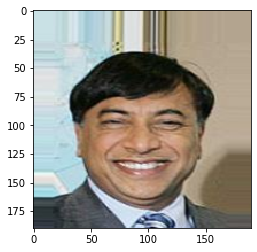

In [13]:
def display_image_from_dataset():
    # Check image
    for batch in data.take(1):
        for img in iter(batch):
            img_ = (img+1)/2
            plt.imshow(img_)
            print(img_.shape, np.min(img_), np.max(img_))
            break
            
display_image_from_dataset()

### Saving functions

In [14]:
def save_generated_image(epoch):
    name = path.join(get_root_path(),
                     generated_images_path,
                     run_name,
                     'img_{}_{}.png'.format(epoch, get_time()))
    plt.savefig(name)

def show_images(images, epoch, img_size=12, save_images=False):
    fig = plt.figure(figsize=(img_size, img_size * 10))

    for i in range(images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(images[i, :, :, :] * 127.5 + 127.5)
        plt.axis('off')

    if save_images:
        save_generated_image(epoch)
    plt.show()

In [15]:
def save_models(generator, discriminator):
    def save(epoch_number):
        path = get_path()
    return save

In [25]:
if collab_mode:
    %reload_ext tensorboard

    log_dir_path = path.join(get_base_path(), tensorboard_logs_dir)
    print('tensorboard log dir {}'.format(log_dir_path))
    %tensorboard --logdir logs
    from tensorboard import notebook
    notebook.list() # View open TensorBoard instances
else:
    print('open tensorboard with command')
    print('tensorboard --logdir {}'.format(log_dir_path))


open tensorboard with command
tensorboard --logdir D:\iswd_2\gsn\laby\FaceGenerator\tensorboard


In [24]:
train_log_dir = 'logs/gradient_tape/' + get_time() + '/train'
test_log_dir = 'logs/gradient_tape/' + get_time() + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

Loss functions


In [26]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def min_max_discriminator_loss(real_out, gen_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    gen_loss = bce(tf.zeros_like(gen_out), gen_out)
    return real_loss + gen_loss


def min_max_generator_loss(gen_out):
    return - min_max_discriminator_loss(tf.ones_like(gen_out), gen_out)


def w_discriminator_loss(real_out, gen_out):
    return - (tf.reduce_mean(real_out) - tf.reduce_mean(gen_out))


def w_generator_loss(gen_out):
    return - tf.reduce_mean(gen_out)

Generator


In [94]:
class Generator(tf.keras.Model):

    def __init__(self, input_shape):
        super().__init__()

        self.noise_decoder = tf.keras.Sequential([
            # flat      
            tf.keras.layers.Dense(7*7*3*256, input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Reshape([7, 7, 3, 256]),
            # conv without stride (7x7)
            tf.keras.layers.Conv3D(128, 5, 1, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # t_conv with stride (14x14)
            tf.keras.layers.Conv3DTranspose(64, 5, 2, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # conv without stride (14x14)
            tf.keras.layers.Conv3D(32, 5, 1, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # t_conv with stride (28x28)
            tf.keras.layers.Conv3DTranspose(32, 5, 2, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            # conv without stride
            tf.keras.layers.Conv3D(1, 5, 1, 'same')
        ])

    def call(self, noise, training):
        return self.noise_decoder(noise)

Discriminator


In [93]:
class Discriminator(tf.keras.Model):

    def __init__(self, input_shape):
        super().__init__()

        # since discriminator is for classification it should be robust, thus, add
        # additional regularization like dropout to prevent from pixel attacks
        print("setting input shape to ", input_size)
        self.image_encoder = tf.keras.Sequential([
            # conv with stride (out = 14x14)
            tf.keras.layers.Conv3D(64, 5, 2, 'same', input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.3),
            # conv with stride (out = 7x7)
            tf.keras.layers.Conv3D(128, 3, 2, 'same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.3),
            # flatten + hidden layer
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dropout(0.3),
            # prediction (LOGITS!)
            tf.keras.layers.Dense(1)
        ])

    def call(self, images, training):
        return self.image_encoder(images)

Noise generator


In [101]:
class NoiseGenerator(tf.keras.layers.Layer):

    def __init__(self, num_classes, distribution_size):
        super().__init__()
        self.distribution_size = distribution_size
        # self.data_distributions = self.add_weight(shape=(num_classes, distribution_size), trainable=True)
        # self.data_distributions = tf.tile(tf.range(0, num_classes, dtype=tf.float32)[:, tf.newaxis], [1, distribution_size])
        # TODO:

    def call(self, inputs):
        # dists = tf.nn.embedding_lookup(self.data_distributions, inputs)
        # dists += tf.random.uniform(tf.shape(dists), -0.35, 0.35)
        # return dists
        # TODO
        print(tf.shape(inputs))
        return tf.random.uniform([tf.shape(inputs)[0], self.distribution_size, 3])

    def diverse_distributions_loss(self):
        # TODO
        return None

Training step



In [83]:
def train_step_template(generator, discriminator, noise, d_optim, g_optim, d_loss_f, g_loss_f):

    @tf.function
    def _train_step_template(images):
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            print("jeden")
            real_out = discriminator(images, True)
            prnit("dwa")
            gen_out = discriminator(generator(noise(images), True), True)
            print("trzy")

        d_loss = d_loss_f(real_out, gen_out)
        g_loss = g_loss_f(gen_out)

        d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, generator.trainable_variables + noise.trainable_variables)

        d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
        g_optim.apply_gradients(zip(g_grads, generator.trainable_variables + noise.trainable_variables))
        
        
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', d_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)


    return _train_step_template


Inference step



In [53]:
def gen_step_template(generator, noise):

    @tf.function
    def _gen_step_template(labels):
        return tf.clip_by_value(generator(noise(labels), False), -1, 1)

    return _gen_step_template

Training

In [79]:
def train(train_step, gen_step, epochs, batch_size, train_data, save_images=True):
    run_name = 'run_{}'.format(get_time())

    for epoch in range(epochs):
        for images in train_data:
            train_step(images)
    
        print('Epoch {0}/{1}'.format(epoch, epochs))

        # images = gen_step()
        # show_images(images, epoch, save_images=save_images)

    

Training with Wasserstein loss function

In [102]:
batch_size = 10
train_data = load_dataset(batch_size=batch_size)

generator_input_shape = (100, 64, 3)
discriminator_input_shape = (batch_size, *IMAGE_SIZES, IMAGE_CHANNELS)
print(generator_input_shape, discriminator_input_shape)

(100, 64, 3) (10, 190, 190, 3)


In [107]:
#generator = Generator(input_shape=generator_input_shape)
#generator.build(input_shape=generator_input_shape)
#generator.summary()

discriminator = Discriminator(input_shape = discriminator_input_shape)
discriminator.build()
discriminator.summary()

setting input shape to  (10, 190, 190, 3)


ResourceExhaustedError: OOM when allocating tensor with shape[884736,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add] name: dense_74/kernel/Initializer/random_uniform/

In [104]:

generator = Generator(input_shape=generator_input_shape)
discriminator = Discriminator(input_shape = discriminator_input_shape)
noise = NoiseGenerator(10, 64)
d_optim = tf.optimizers.Adam(1e-4)
g_optim = tf.optimizers.Adam(1e-4)



train_step = train_step_template(
    generator=generator,
    discriminator=discriminator,
    noise=noise,
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_f=w_discriminator_loss,
    g_loss_f=w_generator_loss,
)

gen_step = gen_step_template(
    generator=generator,
    noise=noise
)

train(
    train_step=train_step, 
    gen_step=gen_step, 
    epochs=30,
    batch_size=256,
    train_data=train_data
)

setting input shape to  (10, 190, 190, 3)
jeden


ValueError: in converted code:

    <ipython-input-83-a2b21fe4d9f2>:7 _train_step_template  *
        real_out = discriminator(images, True)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:847 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    <ipython-input-93-4499cf587428>:31 call  *
        return self.image_encoder(images)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:812 __call__
        self.name)
    d:\iswd_2\gsn\laby\facegenerator\env\lib\site-packages\tensorflow_core\python\keras\engine\input_spec.py:177 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_50 is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: [10, 190, 190, 3]


In [0]:
# save model - download required packages
!pip install -q pyyaml h5py  # Required to save models in HDF5 format


In [0]:
from tensorflow import keras

print(tf.version.VERSION)


2.0.0


In [89]:
discriminator.summary()
generator.summary()

Model: "discriminator_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_37 (Sequential)   (None, 1)                 113493121 
Total params: 113,493,121
Trainable params: 113,492,481
Non-trainable params: 640
_________________________________________________________________


ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.